In [39]:
import pdfplumber
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

In [40]:
import pdfplumber
import pandas as pd

# Open the PDF and extract text
with pdfplumber.open('Historical_Customer_Data_Churn_Prediction.pdf') as pdf:
    pages = pdf.pages
    data = []
    for page in pages:
        tables = page.extract_tables()
        for table in tables:
            data.extend(table)

# Convert extracted data to a DataFrame
data = pd.DataFrame(data[1:], columns=data[0])  # Assuming the first row is the header

In [41]:
data.head(5)

,Customer ID,Start Date,End Date,Usage Freq,Avg. Session Length,Age,Location,Churn Status
0,101,2022-01-15,2023-01-14,20,35,34,New York,1
1,102,2021-06-10,-,15,40,29,California,0
2,103,2023-03-20,-,30,45,45,Texas,0
3,104,2020-11-25,2022-11-24,10,30,38,Florida,1
4,105,2021-08-19,2022-08-18,25,50,27,Illinois,1


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer ID          5 non-null      object
 1   Start Date           5 non-null      object
 2   End Date             5 non-null      object
 3   Usage Freq           5 non-null      object
 4   Avg. Session Length  5 non-null      object
 5   Age                  5 non-null      object
 6   Location             5 non-null      object
 7   Churn Status         5 non-null      object
dtypes: object(8)
memory usage: 448.0+ bytes


In [43]:
data.isnull().sum()

Customer ID            0
Start Date             0
End Date               0
Usage Freq             0
Avg. Session Length    0
Age                    0
Location               0
Churn Status           0
dtype: int64

In [44]:
# Convert columns to numeric
data['Age'] = pd.to_numeric(data['Age'], errors="coerce")
data['Usage Freq'] = pd.to_numeric(data['Usage Freq'], errors='coerce')
data['Avg. Session Length'] = pd.to_numeric(data['Avg. Session Length'], errors='coerce')

# Convert the 'Start Date' and 'End Date' to datetime
data['Start Date'] = pd.to_datetime(data['Start Date'], errors="coerce")
data['End Date'] = pd.to_datetime(data['End Date'], errors="coerce")


le = LabelEncoder()
data['Location'] = le.fit_transform(data['Location'])
data['Churn Status'] = le.fit_transform(data['Churn Status'])

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Customer ID          5 non-null      object        
 1   Start Date           5 non-null      datetime64[ns]
 2   End Date             3 non-null      datetime64[ns]
 3   Usage Freq           5 non-null      int64         
 4   Avg. Session Length  5 non-null      int64         
 5   Age                  5 non-null      int64         
 6   Location             5 non-null      int32         
 7   Churn Status         5 non-null      int32         
dtypes: datetime64[ns](2), int32(2), int64(3), object(1)
memory usage: 408.0+ bytes


EXPLORATORY DATA ANALYSIS (EDA)

HANDLING OUTLIERS IF THERE IS ANY

In [46]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['Age'].quantile(0.25)
Q3 = data['Age'].quantile(0.75)
IQR = Q3 - Q1

# Determine the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset to exclude outliers
data_filtered = data[(data['Age'] >= lower_bound) & (data['Age'] <= upper_bound)]


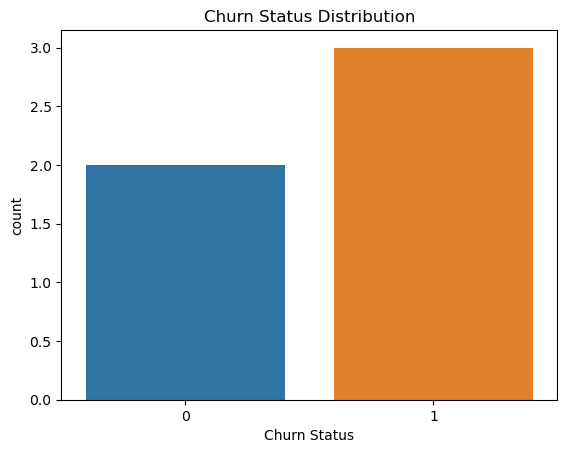

In [47]:
#   Using Histogram to analyse the target variable (Chrun Status)
sns.countplot(x='Churn Status', data = data)
plt.title('Churn Status Distribution')
plt.show()

This plot shows the proportion of customers who chunned against those who did not.
so we have 3.0 for those who chunned against 2.0 for those who didnt.

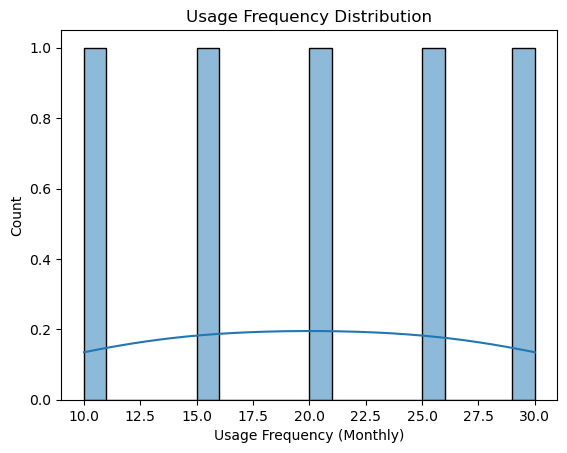

In [48]:
# Plot distribution of Usage Frequency
sns.histplot(data['Usage Freq'], bins=20, kde=True)
plt.title('Usage Frequency Distribution')
plt.xlabel('Usage Frequency (Monthly)')
plt.ylabel('Count')
plt.show()


This shows how customer uses their service, observing whether low or high usage is more common, which might highly be linked to the churn behavior

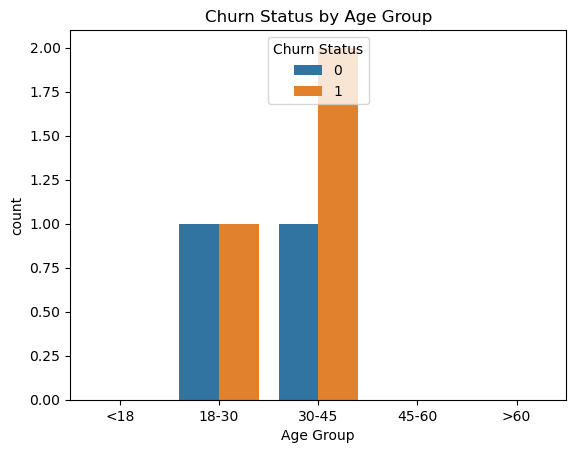

In [50]:
# Create age groups
data['Age Group'] = pd.cut(data['Age'], bins=[0, 18, 30, 45, 60, 100], labels=['<18', '18-30', '30-45', '45-60', '>60'])

# Plot churn status by age group
sns.countplot(x='Age Group', hue='Churn Status', data=data)
plt.title('Churn Status by Age Group')
plt.show()


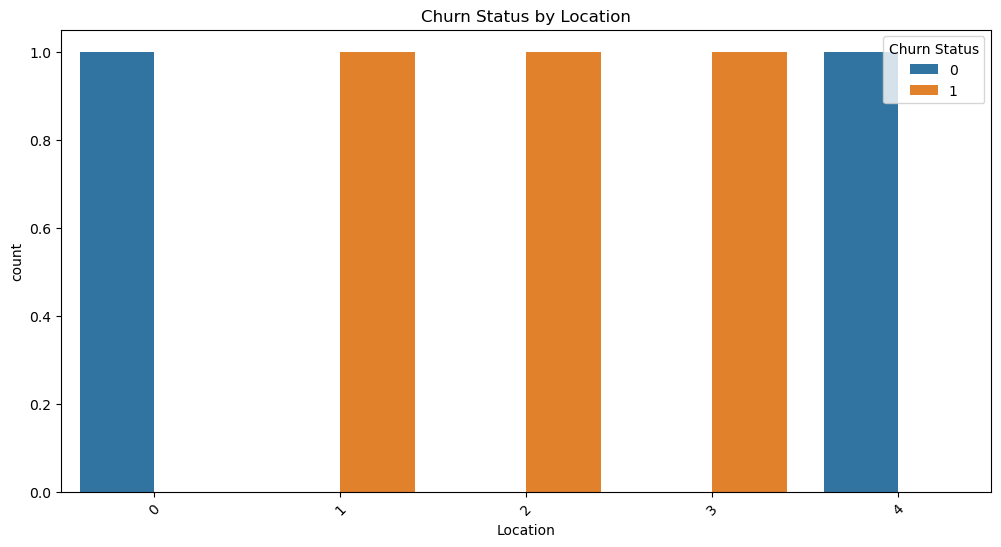

In [51]:
# Create a bar plot for location and churn status
plt.figure(figsize=(12, 6))
sns.countplot(x='Location', hue='Churn Status', data=data)
plt.title('Churn Status by Location')
plt.xticks(rotation=45)
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_17492\82653553.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


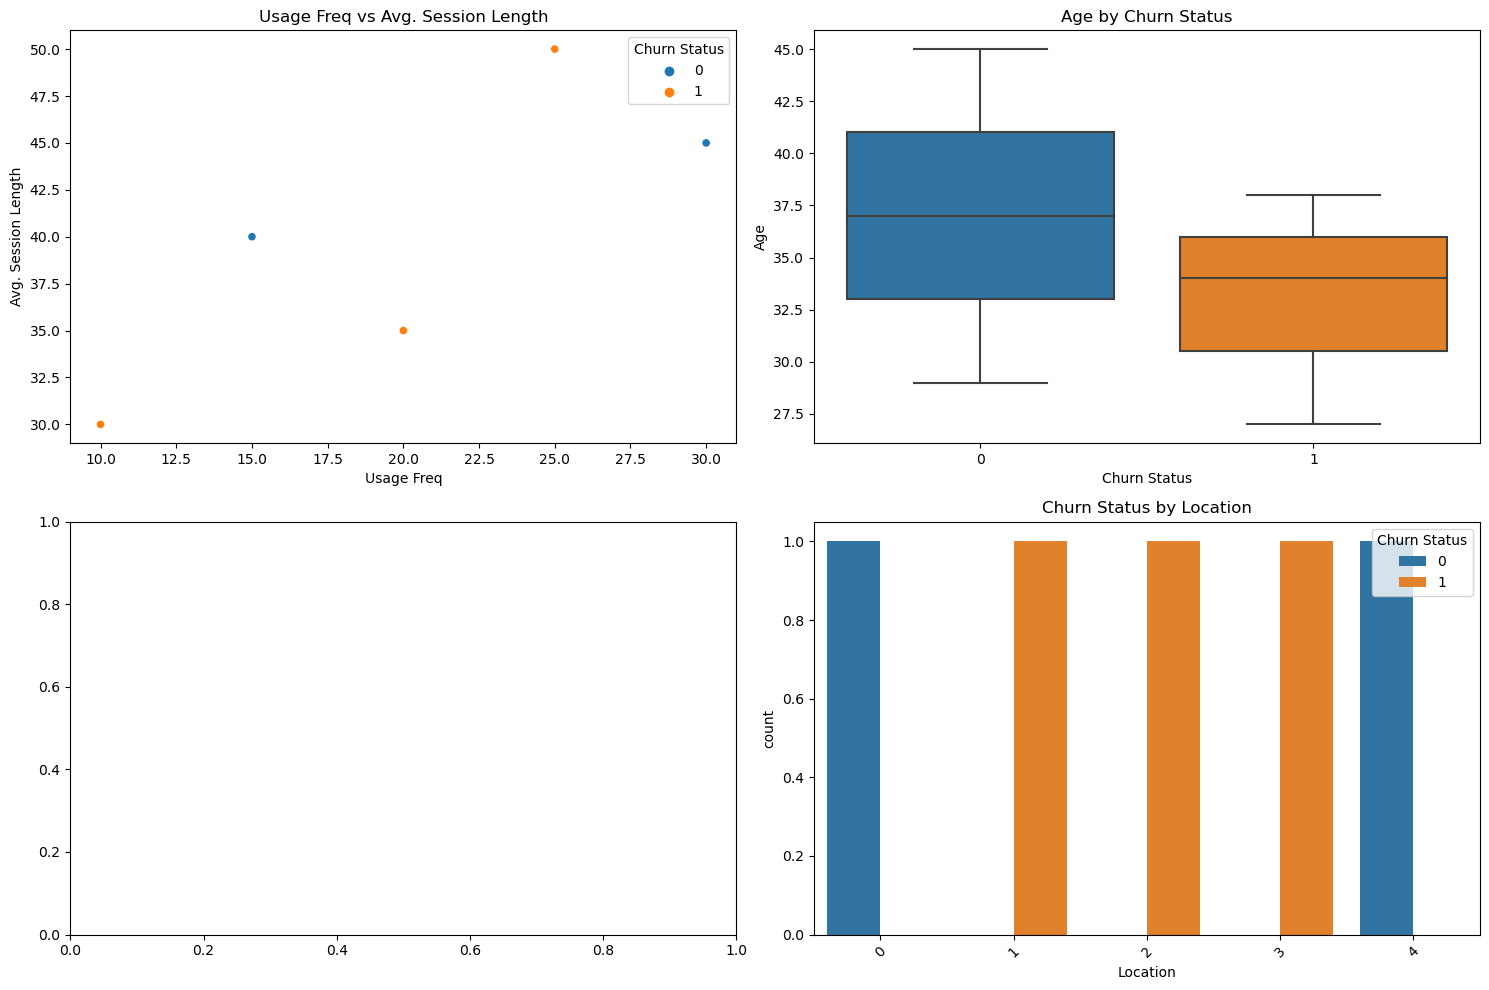

In [52]:
corr_matrix = data.corr()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Pair plot
sns.scatterplot(data=data, x='Usage Freq', y='Avg. Session Length', hue='Churn Status', ax=axs[0, 0])
axs[0, 0].set_title('Usage Freq vs Avg. Session Length')

# Box plot for Age
sns.boxplot(x='Churn Status', y='Age', data=data, ax=axs[0, 1])
axs[0, 1].set_title('Age by Churn Status')

# Count plot for Location
sns.countplot(x='Location', hue='Churn Status', data=data, ax=axs[1, 1])
axs[1, 1].set_title('Churn Status by Location')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


GRAPH ONE:
A scatter plot is created in the top-left subplot (first row, first column). It plots the Usage Freq on the x-axis and Avg. Session Length on the y-axis.
The hue='Churn Status' argument colors the points based on the churn status of customers, allowing to see if there's a relationship between usage frequency, session length, and churn.
The title for this subplot is set to "Usage Freq vs Avg. Session Length".

GRAPH TWO:
A box plot  is created in the top-right subplot (first row, second column). It shows the distribution of Age for different categories of Churn Status.
It helps in visualizing the median, quartiles, and outliers of age data grouped by churn status.
The title for this subplot is set to "Age by Churn Status".

GRAPH THREE:
A count plot in the bottom-right subplot (second row, second column). It counts the occurrences of each Location and splits them based on Churn Status using different colors for each status.
This plot helps visualize how churn varies by location.
The title for this subplot is set to "Churn Status by Location".

FEATURE ENGINEERING

In [53]:
import pandas as pd
from datetime import datetime

# Convert 'End Date' and 'Start Date' to datetime
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce')
data['Start Date'] = pd.to_datetime(data['Start Date'], errors='coerce')

# Calculate Subscription Duration in Months correctly
data['Subscription Duration (Months)'] = ((data['End Date'].fillna(datetime.now()) - data['Start Date'])
                                           / pd.Timedelta(days=30)).astype(int)

# Calculate Total Usage
data['Total Usage'] = data['Usage Freq'] * data['Subscription Duration (Months)']

# Check the updated DataFrame
print(data[['Start Date', 'End Date', 'Subscription Duration (Months)', 'Age', 'Total Usage', 'Location', 'Churn Status']].head())


  Start Date   End Date  Subscription Duration (Months)  Age  Total Usage  \
0 2022-01-15 2023-01-14                              12   34          240   
1 2021-06-10        NaT                              41   29          615   
2 2023-03-20        NaT                              19   45          570   
3 2020-11-25 2022-11-24                              24   38          240   
4 2021-08-19 2022-08-18                              12   27          300   

   Location  Churn Status  
0         3             1  
1         0             0  
2         4             0  
3         1             1  
4         2             1  


In [54]:
data.columns

Index(['Customer ID', 'Start Date', 'End Date', 'Usage Freq',
       'Avg. Session Length', 'Age', 'Location', 'Churn Status', 'Age Group',
       'Subscription Duration (Months)', 'Total Usage'],
      dtype='object')

In [55]:
data.isnull().sum()

Customer ID                       0
Start Date                        0
End Date                          2
Usage Freq                        0
Avg. Session Length               0
Age                               0
Location                          0
Churn Status                      0
Age Group                         0
Subscription Duration (Months)    0
Total Usage                       0
dtype: int64

In [56]:
data['End Date'].fillna(data['End Date'].mean(), inplace=True)

In [57]:
data.isnull().sum()

Customer ID                       0
Start Date                        0
End Date                          0
Usage Freq                        0
Avg. Session Length               0
Age                               0
Location                          0
Churn Status                      0
Age Group                         0
Subscription Duration (Months)    0
Total Usage                       0
dtype: int64

In [58]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize 'Customer Age' and 'Usage Freq'
data[['Age', 'Usage Freq']] =scaler.fit_transform(data[['Age', 'Usage Freq']])

# Display the first few rows of the normalized data
print(data.head())


  Customer ID Start Date            End Date  Usage Freq  Avg. Session Length  \
0         101 2022-01-15 2023-01-14 00:00:00        0.50                   35   
1         102 2021-06-10 2022-11-08 08:00:00        0.25                   40   
2         103 2023-03-20 2022-11-08 08:00:00        1.00                   45   
3         104 2020-11-25 2022-11-24 00:00:00        0.00                   30   
4         105 2021-08-19 2022-08-18 00:00:00        0.75                   50   

        Age  Location  Churn Status Age Group  Subscription Duration (Months)  \
0  0.388889         3             1     30-45                              12   
1  0.111111         0             0     18-30                              41   
2  1.000000         4             0     30-45                              19   
3  0.611111         1             1     30-45                              24   
4  0.000000         2             1     18-30                              12   

   Total Usage  
0        

In [59]:
# convert 'Churn Status' to numeric
data['Churn Status'] = data['Churn Status'].map({'no': 0, 'yes': 1})  # Example mapping
print(data['Churn Status'].isna().sum())  # Count NaN values in Churn Status
# Example of filling NaN with 0 (assuming 0 means not churned)
data['Churn Status'] = data['Churn Status'].fillna(0)  # Or any other appropriate value


5


In [60]:
data.drop(columns = ['Age Group', 'Usage Freq'], inplace=True)

In [61]:
data.head(3)

,Customer ID,Start Date,End Date,Avg. Session Length,Age,Location,Churn Status,Subscription Duration (Months),Total Usage
0,101,2022-01-15,2023-01-14 00:00:00,35,0.388889,3,0.0,12,240
1,102,2021-06-10,2022-11-08 08:00:00,40,0.111111,0,0.0,41,615
2,103,2023-03-20,2022-11-08 08:00:00,45,1.000000,4,0.0,19,570


TRAINING PHASE

In [62]:
X = data[['Age', 'Avg. Session Length', 'Location', 'Subscription Duration (Months)', 'Location', 'Total Usage']]
y = data['Churn Status']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [63]:
X

,Age,Avg. Session Length,Location,Subscription Duration (Months),Location,Total Usage
0,0.388889,35,3,12,3,240
1,0.111111,40,0,41,0,615
2,1.000000,45,4,19,4,570
3,0.611111,30,1,24,1,240
4,0.000000,50,2,12,2,300


MODEL SELECTION USING THE RANDOM FOREST CLASSIFIER

In [64]:
model  = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make prediction
y_pred = model.predict(X_test)

In [65]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'The Accuracy score is: {accuracy}')
print(f'The Precision score is: {precision}')
print(f'The Recall score is: {recall}')
print(f'The F1 Score is: {f1}')

The Accuracy score is: 1.0
The Precision score is: 0.0
The Recall score is: 0.0
The F1 Score is: 0.0


c:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


TO LOAD THE MODEL

In [67]:
# Save the model to a file
with open('customer_churn_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# To load the model later
with open('customer_churn_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)
